# The Battle of the Neighborhoods

This notebook contains [Alan Paredes](https://www.linkedin.com/in/alanparedescetina/)' work on the capstone project for the **IBM Data Scientist Professional Certification.** If you want to kickstart your career in data science & ML. Build data science skills, learn Python & SQL, analyze & visualize data, and build machine learning models, check the [certification](https://www.coursera.org/professional-certificates/ibm-data-science).

## Table of Contents

1.  [Introduction](#item1)  
2.  [Data](#item2)
3.  [Exploration](#item3)
4.  [Clustering](#item4)   
5.  [Conclusion](#item5)
6.  [References](#item6)

<a name="item1"></a>
## Introduction

### 1.1 Background

Mexico City is the capital and largest city of Mexico, where over **9.2** million people live and has a population density of **6,163.3** per square kilometer.[1] The metropolitan area of Great Mexico City has a population of **21.3 million**, making it the second largest metropolitan area in America, only behind Sao Paulo, Brazil. The city is divided in **16** subdivisions (or boroughs), and there are around **15,000** restaurants.[2] Another fact is that the life expectancy of a restaurant in Mexico City is of **6.9** years, not as many as in other Mexican cities.

According to INEGI, Mexico City has a large amount of restaurants per thousand people in comparison to the national average. The subdivision of Benito Juarez has 8 restaurants per thousand people, whereas the national average is of 3 restaurantes per thousand people.[3] There is a high competition but also a large market, hence one of the first decisions that restaurant owners need to make when establishing a new restaurant is where to open it.

### 1.2 Problem

In this project, we will be thinking as a potential restaurant owner. We want to investigate and determine which would be the best category for our new restaurant, and where to open it based on factors such as low competition, low real state costs, and population density. There are several more factors that have an impact when making this decisition, but for the purpose of the scope of this project we will only focus on the already mentioned. 

<a name="item2"></a>
## 2. Data

### 2.1 Data Sources

In order to do this project, we will use the following data:

- [Foursquare API](https://developer.foursquare.com/) Data that contains information of the most common venues in each neighbourhood in Mexico City.
- There isn't a public dataset that concentrates the rental average price per borough in Mexico City. So I set-up my own dataset based on the rental prices of comercial locals advertised in [Inmuebles24](https://www.inmuebles24.com/). The only borough that did not have enough data to be included in this data set was borough Milpa Alta. You can find my data as a CSV file [here](https://github.com/alanpar97/Capstone_Project/blob/master/Data/borough_avg_price.csv).
- We will also use INEGI 2015 Population Data to get the population in each borough. Unfortunately, there is not a more updated dataset yet.
- [Mexican Postal Codes - Mexican Postal Service](https://www.correosdemexico.gob.mx/SSLServicios/ConsultaCP/CodigoPostal_Exportar.aspx) Data that contains the postal codes of each neighbourhood in Mexico City. We will get this data as an XML file provided by the Mexican Postal Service's website.


### 2.2 Getting the Data

Before getting the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import re #library to find string patterns with Regex

from lxml import objectify #library to handle XML files
import requests #library to read files from URL
from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

import matplotlib.pyplot as plt
import seaborn as sns #library to plot data

print('Libraries imported.')

Libraries imported.


#### Loading Mexico City's Postal Codes Data

First, we will get the file from the URL of the document in the respository.

In [4]:
url = "https://raw.githubusercontent.com/alanpar97/Capstone_Project/master/Data/Ciudad%20de%20M%C3%A9xico.xml"

document = requests.get(url)

Parse the xml data using `BeautifulSoup()`.

In [5]:
soup = BeautifulSoup(document.content,"lxml-xml")

We will use Beautiful Soup to extract the table with Mexico City's Neighbourhoods and move it to a data frame named `mexico_city`. The dataset includes postal codes from neighbourhoods, towns, villages, among others. We will only get the ones that belong to neighbourhoods.

In [6]:
mexico_city = pd.DataFrame(columns=["Postal Code","Neighbourhood","Borough"])

for p_code, neigh, borough, place_type in zip(soup.find_all("d_codigo"), soup.find_all("d_asenta"), soup.find_all("D_mnpio"),soup.find_all("d_tipo_asenta")):
    if(place_type.text == "Colonia"): #Colonia means Neighbourhood in spanish
        mexico_city = mexico_city.append({"Postal Code":p_code.text,"Neighbourhood":neigh.text,"Borough":borough.text}, ignore_index=True)   

Let's take a look at our dataframe

In [7]:
mexico_city.head()

Postal Code  Neighbourhood         Borough
0       01000      San Ángel  Álvaro Obregón
1       01010      Los Alpes  Álvaro Obregón
2       01020  Guadalupe Inn  Álvaro Obregón
3       01030        Florida  Álvaro Obregón
4       01040      Campestre  Álvaro Obregón

Let's check the size of our data frame.

In [8]:
mexico_city.shape

(1255, 3)

#### Getting Latitudes and Longitudes

Now that we have built a data frame with each of Mexico City's neighbourhood with their corresponding borough and postal code, in order to use the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighbourhood. 

For this, we will be using `pgeocode` library, which is a Python library for high performance off-line querying of GPS coordinates, region name and municipality name from postal codes.

In [9]:
import pgeocode

In [10]:
nomi = pgeocode.Nominatim("mx")
latitude = []
longitude = []

for postal_code in mexico_city["Postal Code"]:
    info = nomi.query_postal_code(postal_code)
    latitude.append(info.latitude)
    longitude.append(info.longitude)

In [11]:
mexico_city["Latitude"] = latitude
mexico_city["Longitude"] = longitude

Let's check our updated data frame.

In [12]:
mexico_city.head()

Postal Code  Neighbourhood         Borough  Latitude  Longitude
0       01000      San Ángel  Álvaro Obregón   19.3587  -99.20330
1       01010      Los Alpes  Álvaro Obregón   19.3569  -99.21000
2       01020  Guadalupe Inn  Álvaro Obregón   19.5161  -99.14190
3       01030        Florida  Álvaro Obregón   19.3556  -99.17835
4       01040      Campestre  Álvaro Obregón   19.3556  -99.19180

Now that we have data related to the location of Mexico City's neighbourhoods. Let's see how this looks on a map. We will use `folium` library to create maps and marks.

In [13]:
#The latitude and longitud of Mexico City are 19.42847 and -99.12766
map_mexico_city = folium.Map(location=[19.42847, -99.12766], zoom_start=11)

# add markers to map
for lat, lng, borough, neighbourhood in zip(mexico_city['Latitude'], mexico_city['Longitude'], mexico_city['Borough'], mexico_city["Neighbourhood"]):
    label = '{},{}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_mexico_city)

map_mexico_city

#### Getting the Top 20 restaurants per Neighbourhood

Now that we finally have our neighbourhood's data ready, we can use [Foursquare API](https://developer.foursquare.com/) to extract the top 20 restaurants from each neighbourhood. This will play a key role for us when analysing the competition in each neighbourhood.

In [14]:
# Defining credentials
CLIENT_ID = 'V1NV0AUE1AX4QFSV0ZPXDDNMLLDNDZRRFHIROCKSFIIJVX0H' # your Foursquare ID
CLIENT_SECRET = 'TOTMG4OEE0GTQ0GDP4KQ2OGQV3A4L1MGDKRQT25B0YH5DVYF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Before we proceed, lets define a couple functions. The first one will be used to extract the category of the venue. 

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now, we are going to define a function that will go through all the neighbourhoods of Mexico City and get the list of top 20 venues. 

In [26]:
def getNearbyVenues(names, boroughs, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, borough, lat, lng in zip(names, boroughs, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now we are going to run the above function on each neighbourhood and create a new data frame called `mexico_city_venues`

In [28]:
limit = 20 #top list of venues
mexico_city_venues = getNearbyVenues(names=mexico_city["Neighbourhood"],
                                     boroughs=mexico_city["Borough"],
                                     latitudes=mexico_city["Latitude"],
                                     longitudes=mexico_city["Longitude"])

Let's check the resulting dataframe.

In [29]:
mexico_city_venues.head()

Neighborhood         Borough  Neighborhood Latitude  Neighborhood Longitude  \
0    San Ángel  Álvaro Obregón                19.3587                -99.2033   
1    San Ángel  Álvaro Obregón                19.3587                -99.2033   
2    San Ángel  Álvaro Obregón                19.3587                -99.2033   
3    San Ángel  Álvaro Obregón                19.3587                -99.2033   
4    San Ángel  Álvaro Obregón                19.3587                -99.2033   

                   Venue  Venue Latitude  Venue Longitude      Venue Category  
0     D'gusto pastelería       19.359475       -99.203064              Bakery  
1  Quesadillas Doña Sofi       19.360115       -99.204194  Mexican Restaurant  
2  Sukhmaani Yoga Studio       19.360717       -99.203199         Yoga Studio  
3                  Petco       19.359848       -99.203070           Pet Store  
4             La Bellota       19.357408       -99.203194              Bakery

In [30]:
mexico_city_venues.shape

(17797, 8)

How many different categories do we have?

In [31]:
mexico_city_venues["Venue Category"].unique().shape

(379,)

In [32]:
mexico_city_venues.groupby('Venue Category').count().sort_values("Neighborhood", ascending=False).head()

Neighborhood  Borough  Neighborhood Latitude  \
Venue Category                                                     
Taco Place                  2083     2083                   2083   
Mexican Restaurant          1951     1951                   1951   
Bakery                       568      568                    568   
Coffee Shop                  549      549                    549   
Restaurant                   505      505                    505   

                    Neighborhood Longitude  Venue  Venue Latitude  \
Venue Category                                                      
Taco Place                            2083   2083            2083   
Mexican Restaurant                    1951   1951            1951   
Bakery                                 568    568             568   
Coffee Shop                            549    549             549   
Restaurant                             505    505             505   

                    Venue Longitude  
Venue Category                       
Taco Place                     2083  
Mexican Restaurant             1951  
Bakery                          568  
Coffee Shop                     549  
Restaurant                      505

After checking the resulting dataframe, we can see that restaurants have three main keywords:
- Restaurant (e.g. Mexican Restaurant).
- Place (e.g. Pizza Place).
- Joint (e.g. BBQ Joint).

We will also include three different categories that do not contain the above keywords: Food Truck, Steakhouse and Gastropub.

In [33]:
special_restaurants = ["Food Truck","Steakhouse","Gastropub"]

temp = mexico_city_venues[mexico_city_venues["Venue Category"].str.contains('Restaurant|Place|Joint')]
temp1 = mexico_city_venues[pd.DataFrame(mexico_city_venues["Venue Category"].tolist()).isin(special_restaurants).any(1).values]

In [34]:
#Join temporal dataframes
frames = [temp,temp1]
mexico_city_restaurants = pd.concat(frames)
mexico_city_restaurants.reset_index(drop=True, inplace=True)

In [35]:
mexico_city_restaurants.head(5)

Neighborhood         Borough  Neighborhood Latitude  Neighborhood Longitude  \
0    San Ángel  Álvaro Obregón                19.3587                -99.2033   
1    San Ángel  Álvaro Obregón                19.3587                -99.2033   
2    San Ángel  Álvaro Obregón                19.3587                -99.2033   
3    San Ángel  Álvaro Obregón                19.3587                -99.2033   
4    San Ángel  Álvaro Obregón                19.3587                -99.2033   

                   Venue  Venue Latitude  Venue Longitude       Venue Category  
0  Quesadillas Doña Sofi       19.360115       -99.204194   Mexican Restaurant  
1   La Strada Ristorante       19.357996       -99.199605   Italian Restaurant  
2       Nichiboku Kyokai       19.362483       -99.201988  Japanese Restaurant  
3  Quesadillas Espigones       19.357603       -99.203097   Mexican Restaurant  
4         Ay Mi Mazatlán       19.357995       -99.199737            BBQ Joint

Finally, let's check if our data has any missing values.

In [36]:
mexico_city_restaurants.isnull().sum()

Neighborhood              0
Borough                   0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
dtype: int64

As we can see, we don't have any missing values. Our dataset for most common restaurants per neighbourhood is ready.

#### Real State Costs per Borough

There is not enough available data of real state rent costs per neighbourhood, so we are going to focus the real state rental costs per borough. 

In [37]:
url = "https://raw.githubusercontent.com/alanpar97/Capstone_Project/master/Data/borough_avg_price.csv" #Path to file
avg_price = pd.read_csv(url) #Read csv to dataframe
avg_price.head()

ID         Borough  Avg_Price
0   1  Álvaro Obregón     456.80
1   2   Benito Juárez     533.37
2   3        Coyoacán     401.84
3   4      Cuajimalpa     420.59
4   5      Cuauhtémoc     497.20

For the purpose of visualizing this data in a map, we are going to use a geojson file I created with the polygons of each borough in Mexico City.

In [38]:
url = ("https://raw.githubusercontent.com/alanpar97/Capstone_Project/master/Data") #Path to Data folder

mexico_geo = f"{url}/map.geojson" #geojson file with polygons of each borough

#### Population per Borough

Finally, we want to get data regarding the population per each borough. We got the data from [INEGI's website](http://www.cuentame.inegi.org.mx/monografias/informacion/df/territorio/div_municipal.aspx?tema=me&e=09) and save it as csv file. Now we are going to retrieve the data and save it in a dataframe called `boroughs_population`.

In [39]:
#Getting the data from URL
url = "https://raw.githubusercontent.com/alanpar97/Capstone_Project/master/Data/boroughs_population.csv" #Path to file
boroughs_population = pd.read_csv(url) #Read csv and store in dataframe
boroughs_population.head()

Borough  Population
0  Álvaro Obregón      749982
1   Benito Juárez      417416
2        Coyoacán      608479
3      Cuajimalpa      199224
4      Cuauhtémoc      532553

<a name="item3"></a>
## 3. Exploration

Now that we have our data ready, we can start exploring the information we have. 

#### Restaurants in Mexico City

**How many different categories of restaurants are in Mexico City?**

In [40]:
print('There are {} uniques categories.'.format(len(mexico_city_restaurants['Venue Category'].unique())))

There are 65 uniques categories.


**What is the average number of restaurants per neighbourhood?**

In [41]:
neighbourhood_count = mexico_city_restaurants["Neighborhood"].value_counts().to_frame().reset_index().rename(columns={"Neighborhood":"Count","index":"Neighborhood"})

print('The average number of restaurants per neighbourhood is {:.2f}'.format(neighbourhood_count["Count"].mean()))

The average number of restaurants per neighbourhood is 7.06


**Which are the neighbourhoods with most restaurants?**

In [42]:
top_neig = neighbourhood_count.sort_values("Count",ascending=False).head(10)

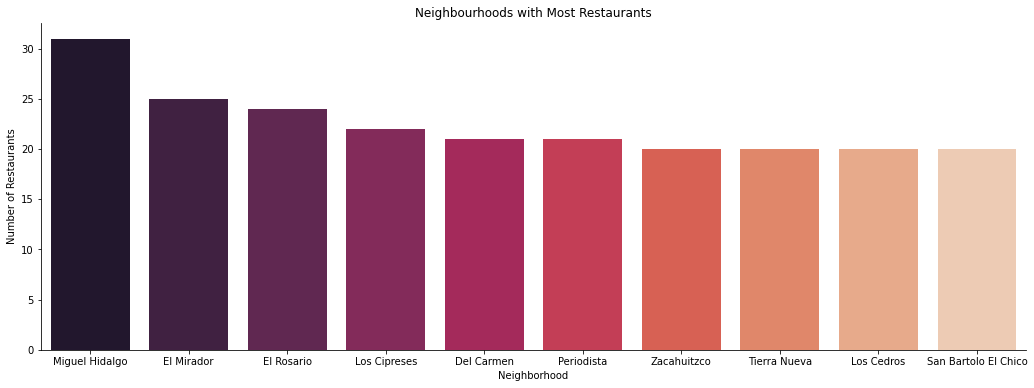

In [43]:
g = sns.catplot(x="Neighborhood", y="Count", kind = "bar",palette="rocket", data=top_neig, height=5.27, aspect=22.7/8.27).set(
    title="Neighbourhoods with Most Restaurants")
g.set_axis_labels("Neighborhood","Number of Restaurants")

These 10 neighbourhoods have an outstanding amount of competitors considering that the average number of restaurants per neighbourhood is 7.

**Which are the neighbourhoods with least restaurants?**

In [44]:
bottom_neig = neighbourhood_count.sort_values("Count",ascending=True).head(10)

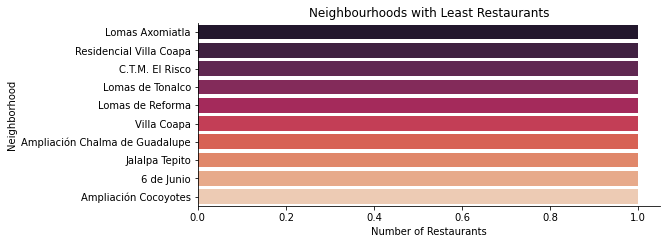

In [45]:
g = sns.catplot(x="Count", y="Neighborhood", kind = "bar",palette="rocket", data=bottom_neig, height=3.27, aspect=23.7/8.27).set(
    title="Neighbourhoods with Least Restaurants")
g.set_axis_labels("Number of Restaurants","Neighborhood")

**How many restaurants are in each borough?**

In [46]:
borough_counts = mexico_city_restaurants["Borough"].value_counts().to_frame().reset_index().rename(columns={"Borough":"Count","index":"Boroughs"})
borough_counts

Boroughs  Count
0           Álvaro Obregón   1271
1               Iztapalapa    997
2        Gustavo A. Madero    859
3                 Coyoacán    661
4           Miguel Hidalgo    625
5                  Tlalpan    572
6      Venustiano Carranza    564
7             Azcapotzalco    505
8            Benito Juárez    493
9               Cuauhtémoc    307
10               Iztacalco    286
11              Xochimilco    249
12   Cuajimalpa de Morelos    217
13                 Tláhuac    122
14  La Magdalena Contreras    113

#### Top 10 Most Popular Categories

In [47]:
categories_count = mexico_city_restaurants["Venue Category"].value_counts().to_frame().reset_index().rename(columns={"Venue Category":"Count","index":"Category"})


top_10 = categories_count.sort_values("Count", ascending=False).head(10)

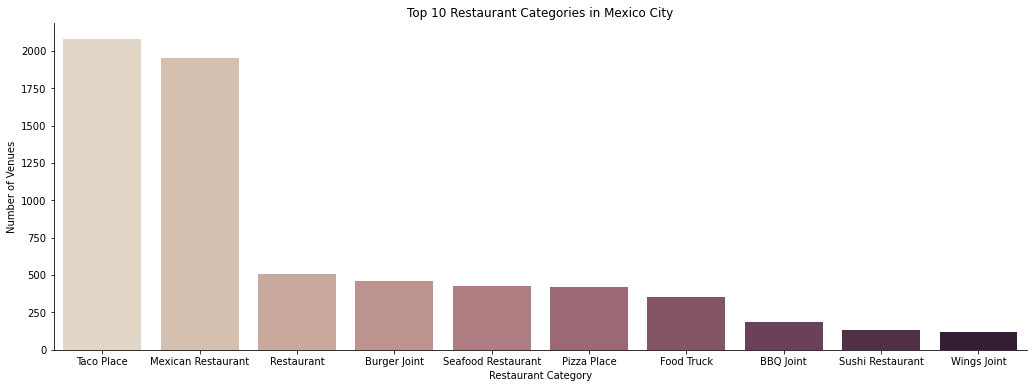

In [48]:
g = sns.catplot(x="Category", y="Count", kind = "bar",palette="ch:.25", data=top_10, height=5.27, aspect=22.7/8.27).set(
    title="Top 10 Restaurant Categories in Mexico City")
g.set_axis_labels("Restaurant Category","Number of Venues")

As we can see in the above plot, mexican food is by far the most popular category in Mexico City. This could be seen as a strongly competitive category, or as a "safe" option to go when picking the category of our restaurant. 

Burger Joints, Seafood Restaurants and Pizza Places are close to each other and could be excellent options to pick as category.

#### Top 10 Least Popular Categories

In [49]:
bottom_10 = categories_count.sort_values("Count", ascending=True).head(10)

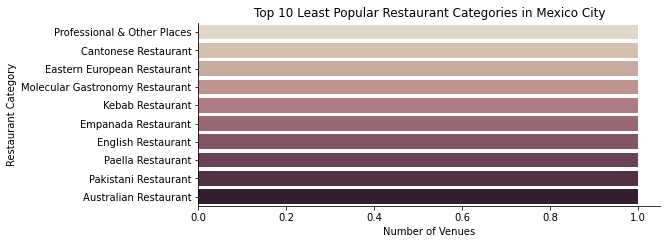

In [50]:
g = sns.catplot(x="Count", y="Category", kind = "bar",palette="ch:.25", data=bottom_10, height=3.27, aspect=23.7/8.27).set(
    title="Top 10 Least Popular Restaurant Categories in Mexico City")
g.set_axis_labels("Number of Venues","Restaurant Category")

A really interesting insight that we can get from this information, is that there are not many restaurants from foreign cuisines. This could be due to the large difference in ingredients that foreign cuisines use that make mexicans not like that food, or maybe mexicans are just traditional eaters.

#### Rent Price per Meter Square per Borough

Now that we have more information regarding the restaurant categories in Mexico City, let's see how much it could cost us to put our restaurant depending on the borough we choose. We will use `folium` library to visualize this.

In [51]:
m = folium.Map(location=[19.42847, -99.12766], zoom_start=10)

folium.Choropleth(
    geo_data=mexico_geo,
    name="choropleth",
    data=avg_price,
    columns=["Borough", "Avg_Price"],
    key_on="feature.properties.mun_name",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Average Rent Price per Borough ($)",
).add_to(m)

folium.LayerControl().add_to(m)

m

#### Top 5 Most Expensive Boroughs

In [52]:
avg_price.sort_values("Avg_Price",ascending=False).head(5)

ID         Borough  Avg_Price
9  10  Miguel Hidalgo     716.17
1   2   Benito Juárez     533.37
4   5      Cuauhtémoc     497.20
0   1  Álvaro Obregón     456.80
3   4      Cuajimalpa     420.59

#### Bottom 5 Most Expensive Boroughs

In [53]:
avg_price.sort_values("Avg_Price",ascending=False).tail(5)

ID              Borough  Avg_Price
7    8           Iztapalapa     253.53
6    7            Iztacalco     235.80
12  13  Venustiano Carranza     223.55
10  11              Tláhuac     214.50
15  16           Milpa Alta        NaN

#### Population per Borough

Now, let's take a look at the population of each borough. This could give us an idea of how much people we could expect in our restaurant depending on the borough we choose.

In [54]:
m = folium.Map(location=[19.42847, -99.12766], zoom_start=10)

folium.Choropleth(
    geo_data=mexico_geo,
    name="choropleth",
    data=boroughs_population,
    columns=["Borough", "Population"],
    key_on="feature.properties.mun_name",
    fill_color="BuPu",
    fill_opacity=0.9,
    line_opacity=0.2,
    legend_name="Population per Borough",
).add_to(m)

folium.LayerControl().add_to(m)

m

#### Top 5 Most Populated Boroughs

In [55]:
boroughs_population.sort_values("Population",ascending=False).head(5)

Borough  Population
7          Iztapalapa     1827868
5   Gustavo A. Madero     1164477
0      Álvaro Obregón      749982
11            Tlalpan      677104
2            Coyoacán      608479

#### Bottom 5 Most Populated Boroughs

In [56]:
boroughs_population.sort_values("Population",ascending=False).tail(5)

Borough  Population
9        Miguel Hidalgo      364439
10              Tláhuac      361593
8   Magdalena Contreras      243886
3            Cuajimalpa      199224
15           Milpa Alta      137927

One interesting insight is that in the case of **Iztapalapa**, it appears as the *most populated* borough in Mexico City, and its included in the list of *least expensive* boroughs. On the contrary, **Miguel Hidalgo** appears as the *most expensive* borough, and it is included in the list of *least populated* boroughs. 

<a name="item4"></a>
## 4. Clustering

Now that we have a better understanding of our data, we are going to create clusters of similar neighbourhoods. We will use **K-Means** to achieve this.

In [57]:
# one hot encoding
mexico_onehot = pd.get_dummies(mexico_city_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
mexico_onehot['Neighbourhood'] = mexico_city_restaurants['Neighborhood'] 

# move neighbourhood column to the first column
fixed_columns = [mexico_onehot.columns[-1]] + list(mexico_onehot.columns[:-1])
mexico_onehot = mexico_onehot[fixed_columns]

mexico_onehot.head()

Neighbourhood  African Restaurant  American Restaurant  Arepa Restaurant  \
0     San Ángel                   0                    0                 0   
1     San Ángel                   0                    0                 0   
2     San Ángel                   0                    0                 0   
3     San Ángel                   0                    0                 0   
4     San Ángel                   0                    0                 0   

   Argentinian Restaurant  Asian Restaurant  Australian Restaurant  BBQ Joint  \
0                       0                 0                      0          0   
1                       0                 0                      0          0   
2                       0                 0                      0          0   
3                       0                 0                      0          0   
4                       0                 0                      0          1   

   Brazilian Restaurant  Burger Joint  Burrito Place  \
0                     0             0              0   
1                     0             0              0   
2                     0             0              0   
3                     0             0              0   
4                     0             0              0   

   Cajun / Creole Restaurant  Cantonese Restaurant  Caribbean Restaurant  \
0                          0                     0                     0   
1                          0                     0                     0   
2                          0                     0                     0   
3                          0                     0                     0   
4                          0                     0                     0   

   Chinese Restaurant  Comfort Food Restaurant  Eastern European Restaurant  \
0                   0                        0                            0   
1                   0                        0                            0   
2                   0                        0                            0   
3                   0                        0                            0   
4                   0                        0                            0   

   Empanada Restaurant  English Restaurant  Falafel Restaurant  \
0                    0                   0                   0   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    0                   0                   0   

   Fast Food Restaurant  Food Truck  French Restaurant  Fried Chicken Joint  \
0                     0           0                  0                    0   
1                     0           0                  0                    0   
2                     0           0                  0                    0   
3                     0           0                  0                    0   
4                     0           0                  0                    0   

   Gastropub  German Restaurant  Gluten-free Restaurant  Greek Restaurant  \
0          0                  0                       0                 0   
1          0                  0                       0                 0   
2          0                  0                       0                 0   
3          0                  0                       0                 0   
4          0                  0                       0                 0   

   Grilled Meat Restaurant  Hot Dog Joint  Indian Restaurant  \
0                        0              0                  0   
1                        0              0                  0   
2                        0              0                  0   
3                        0              0                  0   
4                        0              0                  0   

   Italian Restaurant  Japanese Restaurant  Kebab Restaur

Let's examine the new dataframe size.

In [58]:
mexico_onehot.shape

(7841, 66)

Next, let's group rows by neighbourhood and by taking the mean of the frequency of occurrence of each category.

In [59]:
mexico_grouped = mexico_onehot.groupby('Neighbourhood').mean().reset_index()
mexico_grouped.head()

Neighbourhood  African Restaurant  American Restaurant  \
0       10 de Abril                 0.0                  0.0   
1        10 de Mayo                 0.0                  0.0   
2   12 de Diciembre                 0.0                  0.0   
3      15 de Agosto                 0.0                  0.0   
4  16 de Septiembre                 0.0                  0.0   

   Arepa Restaurant  Argentinian Restaurant  Asian Restaurant  \
0               0.0                     0.0               0.0   
1               0.0                     0.0               0.0   
2               0.0                     0.0               0.0   
3               0.0                     0.0               0.0   
4               0.0                     0.0               0.0   

   Australian Restaurant  BBQ Joint  Brazilian Restaurant  Burger Joint  \
0                    0.0        0.0                   0.0      0.090909   
1                    0.0        0.1                   0.0      0.000000   
2                    0.0        0.0                   0.0      0.000000   
3                    0.0        0.0                   0.0      0.000000   
4                    0.0        0.0                   0.0      0.142857   

   Burrito Place  Cajun / Creole Restaurant  Cantonese Restaurant  \
0            0.0                        0.0                   0.0   
1            0.0                        0.0                   0.0   
2            0.0                        0.0                   0.0   
3            0.0                        0.0                   0.0   
4            0.0                        0.0                   0.0   

   Caribbean Restaurant  Chinese Restaurant  Comfort Food Restaurant  \
0                   0.0                 0.0                      0.0   
1                   0.0                 0.0                      0.0   
2                   0.0                 0.0                      0.0   
3                   0.0                 0.0                      0.0   
4                   0.0                 0.0                      0.0   

   Eastern European Restaurant  Empanada Restaurant  English Restaurant  \
0                          0.0                  0.0                 0.0   
1                          0.0                  0.0                 0.0   
2                          0.0                  0.0                 0.0   
3                          0.0                  0.0                 0.0   
4                          0.0                  0.0                 0.0   

   Falafel Restaurant  Fast Food Restaurant  Food Truck  French Restaurant  \
0                 0.0                   0.0    0.181818                0.0   
1                 0.0                   0.0    0.000000                0.0   
2                 0.0                   0.0    0.000000                0.0   
3                 0.0                   0.0    0.000000                0.0   
4                 0.0                   0.0    0.000000                0.0   

   Fried Chicken Joint  Gastropub  German Restaurant  Gluten-free Restaurant  \
0                  0.0        0.0                0.0                     0.0   
1                  0.0        0.0                0.0                     0.0   
2                  0.0        0.0                0.0                     0.0   
3                  0.0        0.0                0.0                     0.0   
4                  0.0        0.0                0.0                     0.0   

   Greek Restaurant  Grilled Meat Restaurant  Hot Dog Joint  \
0               0.0                      0.0            0.0   
1               0.0                      0.0            0.0   
2               0.0                      0.0            0.0   
3               0.0                      0.0            0.0   
4               0.0                      0.0            0.0   

   Indian Restaurant  Italian Restaurant  Japanese Restaurant  \
0                0.0                 0.0                  0.0   
1                0.0 

Let's confirm the new size.

In [60]:
mexico_grouped.shape

(1111, 66)

#### Top Restaurants per Neighbourhood

First, we'll write a function to sort the venues in descending order.

In [61]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [62]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = mexico_grouped['Neighbourhood']

for ind in np.arange(mexico_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(mexico_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0       10 de Abril    Mexican Restaurant            Restaurant   
1        10 de Mayo            Restaurant           Snack Place   
2   12 de Diciembre            Taco Place    Mexican Restaurant   
3      15 de Agosto            Taco Place  Yucatecan Restaurant   
4  16 de Septiembre            Taco Place          Burger Joint   

  3rd Most Common Venue 4th Most Common Venue      5th Most Common Venue  \
0            Taco Place            Food Truck             Sandwich Place   
1    Mexican Restaurant            Taco Place  Latin American Restaurant   
2  Yucatecan Restaurant   Fried Chicken Joint         English Restaurant   
3             Gastropub    English Restaurant         Falafel Restaurant   
4    Seafood Restaurant    Mexican Restaurant       Yucatecan Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0          Burger Joint     French Restaurant   Empanada Restaurant   
1             BBQ Joint    Seafood Restaurant            Food Truck   
2    Falafel Restaurant  Fast Food Restaurant            Food Truck   
3  Fast Food Restaurant            Food Truck     French Restaurant   
4    Falafel Restaurant  Fast Food Restaurant            Food Truck   

  9th Most Common Venue 10th Most Common Venue  
0    English Restaurant     Falafel Restaurant  
1    English Restaurant     Falafel Restaurant  
2     French Restaurant      German Restaurant  
3   Fried Chicken Joint      German Restaurant  
4     French Restaurant    Fried Chicken Joint

### Finding the best k for K-Means.

The Elbow method is a very popular technique and the idea is to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center (distortions).

In [63]:
mexico_grouped_clustering = mexico_grouped.drop('Neighbourhood', 1)
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(mexico_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

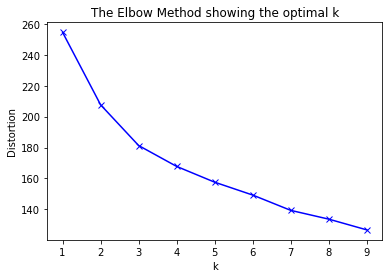

In [64]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the optimal number for k is **3**, so we will have a total of 3 clusters.

### K-Means

Run k-means to cluster the neighborhood into 3 clusters.

In [65]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mexico_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 1, 2, 2, 0, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [69]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mexico_merged = mexico_city

# merge mexico_grouped with mexico_data to add latitude/longitude for each neighbourhood
mexico_merged = mexico_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

#drop NaNs
mexico_merged.dropna(axis=0, inplace=True)
mexico_merged.reset_index(drop=True, inplace=True)

In [70]:
mexico_merged.head()

Postal Code  Neighbourhood         Borough  Latitude  Longitude  \
0       01000      San Ángel  Álvaro Obregón   19.3587  -99.20330   
1       01010      Los Alpes  Álvaro Obregón   19.3569  -99.21000   
2       01020  Guadalupe Inn  Álvaro Obregón   19.5161  -99.14190   
3       01030        Florida  Álvaro Obregón   19.3556  -99.17835   
4       01040      Campestre  Álvaro Obregón   19.3556  -99.19180   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             2.0    Mexican Restaurant    Italian Restaurant   
1             2.0    Mexican Restaurant           Pizza Place   
2             0.0          Burger Joint    Mexican Restaurant   
3             0.0           Wings Joint    Chinese Restaurant   
4             0.0            Restaurant    Mexican Restaurant   

      3rd Most Common Venue 4th Most Common Venue    5th Most Common Venue  \
0                 BBQ Joint   Japanese Restaurant  Grilled Meat Restaurant   
1                Taco Place             Gastropub       Falafel Restaurant   
2               Pizza Place            Taco Place     Yucatecan Restaurant   
3                Food Truck    Mexican Restaurant        French Restaurant   
4  Mediterranean Restaurant            Food Truck        French Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Greek Restaurant         Hot Dog Joint     Indian Restaurant   
1  Fast Food Restaurant            Food Truck     French Restaurant   
2    Falafel Restaurant  Fast Food Restaurant            Food Truck   
3             Gastropub    Falafel Restaurant  Fast Food Restaurant   
4    Italian Restaurant            Taco Place    Spanish Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0    English Restaurant      German Restaurant  
1   Fried Chicken Joint   Yucatecan Restaurant  
2     French Restaurant    Fried Chicken Joint  
3   Fried Chicken Joint      German Restaurant  
4     German Restaurant              Gastropub

#### Finally, let's visualize the resulting clusters

In [71]:
# create map
map_clusters = folium.Map(location=[19.42847, -99.12766], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mexico_merged['Latitude'], mexico_merged['Longitude'], mexico_merged['Neighbourhood'], mexico_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now we can take a moment to examine each cluster.

#### Cluster 1

In [74]:
mexico_merged.loc[mexico_merged['Cluster Labels'] == 0, mexico_merged.columns[[1] + list(range(5, mexico_merged.shape[1]))]].head(10)

Neighbourhood  Cluster Labels 1st Most Common Venue  \
2         Guadalupe Inn             0.0          Burger Joint   
3               Florida             0.0           Wings Joint   
4             Campestre             0.0            Restaurant   
6             Altavista             0.0   Japanese Restaurant   
7         San Ángel Inn             0.0   Japanese Restaurant   
8           Chimalistac             0.0  Brazilian Restaurant   
9      Progreso Tizapan             0.0            Taco Place   
10       Ermita Tizapan             0.0            Taco Place   
13  Belém de las Flores             0.0    Mexican Restaurant   
14           El Capulín             0.0    Mexican Restaurant   

   2nd Most Common Venue     3rd Most Common Venue 4th Most Common Venue  \
2     Mexican Restaurant               Pizza Place            Taco Place   
3     Chinese Restaurant                Food Truck    Mexican Restaurant   
4     Mexican Restaurant  Mediterranean Restaurant            Food Truck   
6       Swiss Restaurant         French Restaurant            Restaurant   
7       Swiss Restaurant         French Restaurant            Restaurant   
8            Pizza Place   Comfort Food Restaurant     French Restaurant   
9     Mexican Restaurant              Burger Joint      Tapas Restaurant   
10    Mexican Restaurant              Burger Joint      Tapas Restaurant   
13            Taco Place                Food Truck           Wings Joint   
14            Taco Place                Food Truck           Wings Joint   

     5th Most Common Venue 6th Most Common Venue   7th Most Common Venue  \
2     Yucatecan Restaurant    Falafel Restaurant    Fast Food Restaurant   
3        French Restaurant             Gastropub      Falafel Restaurant   
4        French Restaurant    Italian Restaurant              Taco Place   
6       Mexican Restaurant  Brazilian Restaurant  Gluten-free Restaurant   
7       Mexican Restaurant  Brazilian Restaurant  Gluten-free Restaurant   
8       Mexican Restaurant            Restaurant              Taco Place   
9   Argentinian Restaurant           Salad Place      Spanish Restaurant   
10             Salad Place  Fast Food Restaurant      Spanish Restaurant   
13             Pizza Place   Fried Chicken Joint      Falafel Restaurant   
14             Pizza Place   Fried Chicken Joint      Falafel Restaurant   

     8th Most Common Venue   9th Most Common Venue   10th Most Common Venue  
2               Food Truck       French Restaurant      Fried Chicken Joint  
3     Fast Food Restaurant     Fried Chicken Joint        German Restaurant  
4       Spanish Restaurant       German Restaurant                Gastropub  
6        German Restaurant        Greek Restaurant  Grilled Meat Restaurant  
7        German Restaurant        Greek Restaurant  Grilled Meat Restaurant  
8   Argentinian Restaurant  Gluten-free Restaurant        German Restaurant  
9     Yucatecan Restaurant      Falafel Restaurant     Fast Food Restaurant  
10    Yucatecan Restaurant      English Restaurant       Falafel Restaurant  
13    Fast Food Restaurant       French Restaurant     Yucatecan Restaurant  
14    Fast Food Restaurant       French Restaurant     Yucatecan Restaurant

#### Cluster 2

In [75]:
mexico_merged.loc[mexico_merged['Cluster Labels'] == 1, mexico_merged.columns[[1] + list(range(5, mexico_merged.shape[1]))]].head(10)

Neighbourhood  Cluster Labels 1st Most Common Venue  \
26                   Bellavista             1.0            Taco Place   
27       José Maria Pino Suárez             1.0            Taco Place   
29                      Tolteca             1.0            Taco Place   
75             Lomas de Becerra             1.0    Seafood Restaurant   
76                       Arvide             1.0            Taco Place   
77                    El Pocito             1.0            Taco Place   
79                      La Joya             1.0            Taco Place   
80                     El Rodeo             1.0            Taco Place   
81        Reacomodo El Cuernito             1.0            Taco Place   
98  Olivar del Conde 1a Sección             1.0            Taco Place   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
26    Mexican Restaurant            Restaurant  Fast Food Restaurant   
27    Mexican Restaurant            Restaurant        Sandwich Place   
29    Mexican Restaurant             BBQ Joint      Sushi Restaurant   
75            Taco Place   Fried Chicken Joint  Yucatecan Restaurant   
76  Fast Food Restaurant  Yucatecan Restaurant             Gastropub   
77  Fast Food Restaurant  Yucatecan Restaurant             Gastropub   
79    Mexican Restaurant  Fast Food Restaurant            Soup Place   
80    Mexican Restaurant    Seafood Restaurant   Fried Chicken Joint   
81    Mexican Restaurant        Sandwich Place            Food Truck   
98      Asian Restaurant    Mexican Restaurant            Food Truck   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
26        Sandwich Place            Steakhouse             BBQ Joint   
27            Steakhouse             BBQ Joint          Burger Joint   
29            Soup Place   Fried Chicken Joint    English Restaurant   
75    English Restaurant    Falafel Restaurant  Fast Food Restaurant   
76    English Restaurant    Falafel Restaurant            Food Truck   
77    English Restaurant    Falafel Restaurant            Food Truck   
79             BBQ Joint             Gastropub    Falafel Restaurant   
80  Fast Food Restaurant            Food Truck            Soup Place   
81            Steakhouse   Fried Chicken Joint    English Restaurant   
98      Sushi Restaurant  Yucatecan Restaurant             Gastropub   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
26          Burger Joint  Yucatecan Restaurant     Falafel Restaurant  
27  Yucatecan Restaurant    Falafel Restaurant   Fast Food Restaurant  
29    Falafel Restaurant  Fast Food Restaurant             Food Truck  
75            Food Truck     French Restaurant              Gastropub  
76     French Restaurant   Fried Chicken Joint      German Restaurant  
77     French Restaurant   Fried Chicken Joint      German Restaurant  
79            Food Truck     French Restaurant    Fried Chicken Joint  
80  Yucatecan Restaurant           Wings Joint              Gastropub  
81    Falafel Restaurant  Fast Food Restaurant      French Restaurant  
98    Falafel Restaurant  Fast Food Restaurant      French Restaurant

#### Cluster 3

In [76]:
mexico_merged.loc[mexico_merged['Cluster Labels'] == 2, mexico_merged.columns[[1] + list(range(5, mexico_merged.shape[1]))]].head(10)

Neighbourhood  Cluster Labels  \
0                              San Ángel             2.0   
1                              Los Alpes             2.0   
5   Ex-Hacienda de Guadalupe Chimalistac             2.0   
11                               Pólvora             2.0   
12                           La Conchita             2.0   
22                               Paraíso             2.0   
23               Molino de Santo Domingo             2.0   
24                        Real del Monte             2.0   
34                   Abraham M. González             2.0   
39                               Bonanza             2.0   

   1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0     Mexican Restaurant    Italian Restaurant             BBQ Joint   
1     Mexican Restaurant           Pizza Place            Taco Place   
5     Mexican Restaurant  Yucatecan Restaurant   Empanada Restaurant   
11    Mexican Restaurant            Taco Place          Burger Joint   
12    Mexican Restaurant            Taco Place      Sushi Restaurant   
22    Mexican Restaurant            Taco Place           Wings Joint   
23    Mexican Restaurant            Taco Place           Wings Joint   
24    Mexican Restaurant            Taco Place           Wings Joint   
34    Mexican Restaurant            Taco Place    Seafood Restaurant   
39            Taco Place    Mexican Restaurant  Yucatecan Restaurant   

   4th Most Common Venue    5th Most Common Venue    6th Most Common Venue  \
0    Japanese Restaurant  Grilled Meat Restaurant         Greek Restaurant   
1              Gastropub       Falafel Restaurant     Fast Food Restaurant   
5      Indian Restaurant            Hot Dog Joint  Grilled Meat Restaurant   
11            Soup Place               Restaurant              Wings Joint   
12    Italian Restaurant         Greek Restaurant  Grilled Meat Restaurant   
22            Food Truck               Restaurant      Fried Chicken Joint   
23            Food Truck               Restaurant      Fried Chicken Joint   
24            Food Truck               Restaurant      Fried Chicken Joint   
34            Restaurant     Yucatecan Restaurant               Food Truck   
39   Fried Chicken Joint       English Restaurant       Falafel Restaurant   

     7th Most Common Venue   8th Most Common Venue 9th Most Common Venue  \
0            Hot Dog Joint       Indian Restaurant    English Restaurant   
1               Food Truck       French Restaurant   Fried Chicken Joint   
5         Greek Restaurant  Gluten-free Restaurant     German Restaurant   
11      Seafood Restaurant              Food Truck    English Restaurant   
12  Gluten-free Restaurant           Hot Dog Joint     German Restaurant   
22      English Restaurant      Falafel Restaurant  Fast Food Restaurant   
23      English Restaurant      Falafel Restaurant  Fast Food Restaurant   
24      English Restaurant      Falafel Restaurant  Fast Food Restaurant   
34     Empanada Restaurant      English Restaurant    Falafel Restaurant   
39    Fast Food Restaurant              Food Truck     French Restaurant   

   10th Most Common Venue  
0       German Restaurant  
1    Yucatecan Restaurant  
5               Gastropub  
11     Falafel Restaurant  
12    Empanada Restaurant  
22      French Restaurant  
23      French Restaurant  
24      French Restaurant  
34   Fast Food Restaurant  
39      German Restaurant

<a name="item5"></a>
## 5. Conclusion

Mexico City is one of the biggest metropolitan areas in the world, with such a big population and narrow area. It is a great place to have a restaurant if you know what to sell and where to sell. 

It is clear that the amount of mexican restaurants is overwhelming, and it is similar to other countries like Italy that have strong traditional cuisines. You could open another Taco Place and there is a high chance it would work, or maybe you can pick one of the less common categories and try to get its niche market. Everything depends on your strategy.

Regarding where to open depending on Population and Real State costs, the clear winner was Iztapalapa being the most populated borough and one of the least expensive boroughs; but then again, there are several factors that because of the scope of the project were not considered and its advisible to check before making a decision, such as crminality index, and average salary of people living in the borough. 

In the future, it would be interesting to analyze amount of offices in each neighborhood, that way you could know which neighborhoods would have the most amout of people during weekdays that could be potential lunch clients. 

<a name="item6"></a>
## 6. References

- [1] [INEGI - Population per Federal Entity](https://www.inegi.org.mx/app/tabulados/interactivos/?pxq=Poblacion_Poblacion_01_e60cd8cf-927f-4b94-823e-972457a12d4b)
- [2] [Mexico City - Wikipedia](https://en.wikipedia.org/wiki/Mexico_City#cite_note-18)
- [3] [CANIRAC - INEGI (PDF)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiplbqTlJXvAhWlp1kKHQ7QAUYQFjABegQIBRAD&url=http%3A%2F%2Fcanirac.org.mx%2Fimages%2Fen_su_punto%2Ffiles%2Finegi.pdf&usg=AOvVaw3sFn8woiT6IBoYRCLmIJhe)